In [2]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [25]:
import subprocess

input_files = ['../../resources/matrices/e40r5000.mtx',
               '../../resources/matrices/Serena/Serena.mtx',
               '../../resources/matrices/Flan_1565/Flan_1565.mtx',
               '../../resources/matrices/nlpkkt200/nlpkkt200.mtx',
               ]

for file in input_files:
    subprocess.run(f"h5dump -A {file.replace('.mtx', '.csr.h5')}", shell=True)


HDF5 "../../resources/matrices/e40r5000.csr.h5" {
GROUP "/" {
   GROUP "A" {
      ATTRIBUTE "MATLAB_sparse" {
         DATATYPE  H5T_STD_U64LE
         DATASPACE  SCALAR
         DATA {
         (0): 17281
         }
      }
      DATASET "data" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 553956 ) / ( 553956 ) }
      }
      DATASET "ir" {
         DATATYPE  H5T_STD_U64LE
         DATASPACE  SIMPLE { ( 553956 ) / ( 553956 ) }
      }
      DATASET "jc" {
         DATATYPE  H5T_STD_U64LE
         DATASPACE  SIMPLE { ( 17282 ) / ( 17282 ) }
      }
   }
}
}
HDF5 "../../resources/matrices/Serena/Serena.csr.h5" {
GROUP "/" {
   GROUP "A" {
      ATTRIBUTE "MATLAB_sparse" {
         DATATYPE  H5T_STD_U64LE
         DATASPACE  SCALAR
         DATA {
         (0): 1391349
         }
      }
      DATASET "data" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 64531701 ) / ( 64531701 ) }
      }
      DATASET "ir" {
         DATATYPE  H5T_STD_U64LE
  

[2007086.95652174 4933239.12544912 4696241.76       6423503.23163129] 4515017.76840054
[2840800.         6620673.13019391 6931108.3298896  7880197.46835443] 6068194.732109485
[4.58554589e+07 1.69578963e+08 8.12628881e+07 1.43326062e+08] 110005843.06783956
1.3440024033967786 24.36443192709948 18.12826514708737


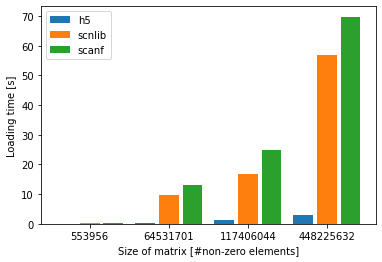

In [33]:
scanf = np.array([0.276,
                  13.081,
                  25.000,
                  69.779])

scnlib = np.array([0.195,
                   9.747,
                   16.939,
                   56.880])

h5 = np.array([0.012080481,
               0.380540722,
               1.444768292,
               3.127314214])

sizes = np.array([553956, 64531701, 117406044, 448225632])

scanf_throughput = sizes / scanf
scnlib_throughput = sizes / scnlib
h5_throughput = sizes / h5

scanf_avg_thr = np.average(scanf_throughput)
scnlib_avg_thr = np.average(scnlib_throughput)
h5_avg_thr = np.average(h5_throughput)

print(scanf_throughput, scanf_avg_thr)
print(scnlib_throughput, scnlib_avg_thr)
print(h5_throughput, h5_avg_thr)

print(scnlib_avg_thr / scanf_avg_thr, h5_avg_thr /
      scanf_avg_thr, h5_avg_thr / scnlib_avg_thr)

X_axis = np.arange(4)

plt.bar(X_axis - 0.3, h5, 0.25, label='h5')
plt.bar(X_axis, scnlib, 0.25, label='scnlib')
plt.bar(X_axis + 0.3, scanf, 0.25, label='scanf')
plt.xticks(X_axis, h5_sizes)
plt.xlabel("Size of matrix [#non-zero elements]")
plt.ylabel("Loading time [s]")
plt.title("")
plt.legend()
plt.savefig('matrix_loading.png')
plt.show()
